<a href="https://colab.research.google.com/github/olhacherenkova/Python-projects/blob/main/User_%26_Sales_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install scikit_posthocs

In [ ]:
# Імпорт необхідних таблиць
from google.colab import auth
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy import stats
import numpy as np
from scipy.stats import shapiro
from scipy.stats import kruskal
import scikit_posthocs as sp

In [ ]:
# Аутентифікація
auth.authenticate_user()

In [ ]:
# Створення клієнта для BigQuery
client = bigquery.Client(project="data-analytics-mate")

In [ ]:
# SQL-запит до бази даних
query = """
SELECT s.date,
  s.ga_session_id,
  sp.continent,
  sp.country,
  sp.device,
  sp.browser,
  sp.mobile_model_name,
  sp.operating_system,
  sp.language,
  sp.medium,
  sp.channel,
  ass.account_id,
  acc.is_verified,
  acc.is_unsubscribed,
  p.category,
  p.name,
  p.price,
  p.short_description
FROM `data-analytics-mate.DA.session` s
LEFT JOIN `data-analytics-mate.DA.session_params` sp
ON s.ga_session_id = sp.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account_session` ass
ON s.ga_session_id = ass.ga_session_id
LEFT JOIN `data-analytics-mate.DA.account` acc
ON ass.account_id = acc.id
LEFT JOIN `data-analytics-mate.DA.order` o
ON s.ga_session_id = o.ga_session_id
LEFT JOIN `data-analytics-mate.DA.product` p
ON o.item_id = p.item_id

"""
# Виконання запиту
query_job = client.query(query)
results = query_job.result()
# Перетворення результатів на DataFrame
df = results.to_dataframe()
# Виведення результату
df.head()


,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,account_id,is_verified,is_unsubscribed,category,name,price,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(none),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [ ]:
# Вивиедення інформації про DataFrame
df.info()
# Перевірка на навяність дублікатів
print(df.duplicated())
# Визначення періоду, що розглядається
print(df['date'].max())
print(df['date'].min())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  Int64  
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   Int64  
 12  is_verified        27945 non-null   Int64  
 13  is_unsubscribed    27945 non-null   Int64  
 14  category           33538 non-null   object 
 15  name               33538 non-null   object 
 16  pr

In [ ]:
# Перетворення полів ga_session_id, account_id,is_verified ,is_unsubscribed на числові поля
df["ga_session_id"] = df["ga_session_id"].astype("object")
df["account_id"] = df["account_id"].astype("object")
df["is_verified"] = df["is_verified"].astype("object")
df["is_unsubscribed"] = df["is_unsubscribed"].astype("object")
# Зміна назви колонки price
df.rename(columns={"price": "sales"}, inplace=True)


In [ ]:
# Перевірка проведених змін
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349545 entries, 0 to 349544
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   date               349545 non-null  dbdate 
 1   ga_session_id      349545 non-null  object 
 2   continent          349545 non-null  object 
 3   country            349545 non-null  object 
 4   device             349545 non-null  object 
 5   browser            349545 non-null  object 
 6   mobile_model_name  349545 non-null  object 
 7   operating_system   349545 non-null  object 
 8   language           235279 non-null  object 
 9   medium             349545 non-null  object 
 10  channel            349545 non-null  object 
 11  account_id         27945 non-null   object 
 12  is_verified        27945 non-null   object 
 13  is_unsubscribed    27945 non-null   object 
 14  category           33538 non-null   object 
 15  name               33538 non-null   object 
 16  sa

Короткий опис отриманого датасету:
 - загальна кількість колонок - 18
 - кількість колонок числового типу  - 1 (sales)
 - кількість колонок категоріального типу  - 17 (continent,country, device, browser, mobile_model_name, operating_system, language, medium,channel,  category, name, short_description, ga_session_id, account_id, is_verified , is_unsubscribed)
 - кількість колонок типу datetime - 1 (date)
 - кількість унікальних сесій - 33538
 - період часу, що розглядається  - від 2020-11-01  до 2021-01-27
 - чи є пропущені значення - так, в колонках category, name, sales, short_description, оскільки покупки відбуваються не на всіх сесіях коритувачів.В колонках account_id, is_verified, is_unsubscribed є пропущені значення, оскільки не всі користувачі, що зробили покупки зареєстровані. Є також відсутні значення в колонці language.


In [ ]:
df.head(10)

,date,ga_session_id,continent,country,device,browser,mobile_model_name,operating_system,language,medium,channel,account_id,is_verified,is_unsubscribed,category,name,sales,short_description
0,2020-11-01,5760483956,Americas,United States,desktop,Chrome,Safari,Macintosh,zh,<Other>,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
1,2020-11-01,7115337200,Europe,United Kingdom,desktop,Chrome,Chrome,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
2,2020-11-01,3978035233,Europe,Norway,mobile,Chrome,<Other>,Web,zh,(none),Direct,<NA>,<NA>,<NA>,Tables & desks,RÅSKOG,189.0,"Trolley, 35x45x78 cm"
3,2020-11-01,9648986282,Africa,Nigeria,mobile,Chrome,<Other>,Android,es-es,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
4,2020-11-01,4393441533,Asia,China,desktop,Chrome,Chrome,Windows,en-us,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
5,2020-11-01,967742695,Americas,United States,desktop,Safari,Safari,Web,en-us,(data deleted),Undefined,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
6,2020-11-01,1115082532,Europe,Germany,desktop,Chrome,Safari,Macintosh,None,referral,Paid Search,<NA>,<NA>,<NA>,Cabinets & cupboards,GALANT,2270.0,"Storage combination with drawers, 80x160 cm"
7,2020-11-01,6586349543,Americas,(not set),desktop,Chrome,Safari,Web,en-us,referral,Paid Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
8,2020-11-01,5041302343,Americas,Ecuador,desktop,Chrome,Chrome,Web,en-us,organic,Organic Search,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"
9,2020-11-01,1129172264,Americas,United States,mobile,Chrome,<Other>,Android,en-us,(none),Direct,<NA>,<NA>,<NA>,Bookcases & shelving units,VITTSJÖ,609.0,"Shelving unit with laptop table, 202x36x175 cm"


In [ ]:
# Aналіз продажів у розрізі девайсів
group_by_device = df.groupby(["device"])["sales"].sum().reset_index()
group_by_device["Percent"] = (group_by_device["sales"] / group_by_device["sales"].sum() * 100).round(3)
print (group_by_device)

    device       sales  Percent
0  desktop  18864039.0   59.002
1   mobile  12384225.8   38.735
2   tablet    723466.3    2.263


Найбільше покупок відбувається на дестопних присторях, потім на мобільних пристроях, найменше купують з планшетів.

In [ ]:
# Aналіз кількості серсій у розрізі девайсів
group_by_device_session= df.groupby(["device"])["sales"].count().reset_index()
group_by_device_session["Percent"] = (group_by_device_session["sales"] / group_by_device_session["sales"].sum() * 100).round(3)
print (group_by_device_session)

    device  sales  Percent
0  desktop  19702   58.745
1   mobile  13113   39.099
2   tablet    723    2.156


Найбільше сесій відбувається з дестопних присторях, на другому місці - мобільні пристрої, найменше сесій з планшетів.

In [ ]:
# Aналіз продажів у розрізі девайсів та моделей пристроїв
group_by_device_and_model = df.groupby(["device","mobile_model_name"])["sales"].sum().reset_index()
group_by_device_and_model["Percent"] = (group_by_device_and_model["sales"] / group_by_device_and_model["sales"].sum() * 100).round(3)
print (group_by_device_and_model)

     device mobile_model_name      sales  Percent
0   desktop           <Other>   525645.1    1.644
1   desktop            Chrome  8899523.9   27.836
2   desktop        ChromeBook  1830458.7    5.725
3   desktop              Edge   696877.3    2.180
4   desktop           Firefox   421066.9    1.317
5   desktop            Safari  6490467.1   20.301
6    mobile           <Other>  5735073.6   17.938
7    mobile              Edge      345.0    0.001
8    mobile           Pixel 3   109148.2    0.341
9    mobile        Pixel 4 XL   118287.7    0.370
10   mobile            Safari      595.0    0.002
11   mobile            iPhone  6420776.3   20.083
12   tablet           <Other>   274612.1    0.859
13   tablet              iPad   448854.2    1.404


Найбільше купують з desktop пристроїв з браузером Chrome, на мобільних пристроях найбільше купіють з iPhone, на планшетах найбільше купують з iPad.  

In [ ]:
# Aналіз продажів за джерелами трафіку
group_by_channel = df.groupby(["channel"])["sales"].sum().reset_index()
group_by_channel["percent"] = (group_by_channel["sales"] / group_by_channel["sales"].sum() * 100).round(3)
group_by_channel = group_by_channel.sort_values(by="percent", ascending=False)
print(group_by_channel)

          channel       sales  percent
1  Organic Search  11433151.6   35.760
2     Paid Search   8511049.4   26.621
0          Direct   7494923.4   23.442
3   Social Search   2532105.7    7.920
4       Undefined   2000501.0    6.257


Найбільше продажів приносять органічні канали трафіку, на 2 місці  - платні джерела, на 3 - direct, на 4 - перехід з соцмереж, на останньому - невідомі джерела.


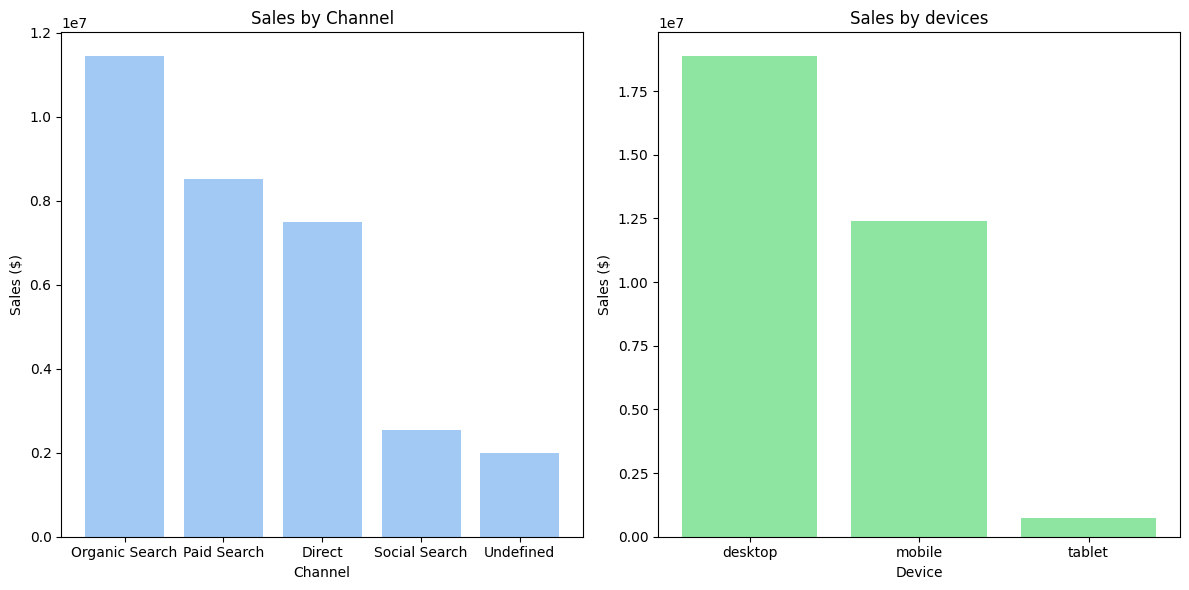

In [ ]:
# Візуалізація продажів за джерелами трафіку та девайсами
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
colors = sns.color_palette("pastel")

ax[0].bar(group_by_channel["channel"], group_by_channel["sales"], color=colors[0])
ax[0].set_title("Sales by Channel")
ax[0].set_xlabel("Channel")
ax[0].set_ylabel("Sales ($)")

ax[1].bar(group_by_device["device"], group_by_device["sales"], color=colors[2])
ax[1].set_title("Sales by devices")
ax[1].set_xlabel("Device")
ax[1].set_ylabel("Sales ($)")

plt.tight_layout()
plt.show()

In [ ]:
# Середній чек по девайсам
group_by_device_avg_sales = df.groupby(["device"])["sales"].mean().reset_index()
group_by_device_avg_sales = group_by_device_avg_sales.sort_values(by ="sales", ascending=False)
print(group_by_device_avg_sales)

    device        sales
2   tablet  1000.644952
0  desktop   957.468227
1   mobile   944.423534


Найбільший середній чек в розрізі девайсів - на планшетах. Десктопи - стабільний сегмент. Мобільні пристрої - найнижчий чек.

In [ ]:
# Середній чек по каналам
group_by_channel_avg_sales = df.groupby(["channel"])["sales"].mean().reset_index()
group_by_channel_avg_sales = group_by_channel_avg_sales.sort_values(by ="sales", ascending=False)
print(group_by_channel_avg_sales)

          channel       sales
4       Undefined  971.588635
0          Direct  960.887615
1  Organic Search  959.076554
2     Paid Search  941.279518
3   Social Search  932.292231


Найбільший середній чек в розрізі каналів - на невідових джерелах трафіку, варто дослідити невідомі джерела трафіку детальніше. Direct і Organic Search - найефективніші канали з точки зору середнього чека.

           channel   device        sales
0           Direct  desktop   960.818346
1           Direct   mobile   963.255578
2           Direct   tablet   918.725625
3   Organic Search  desktop   969.064014
4   Organic Search   mobile   947.126767
5   Organic Search   tablet   902.622353
6      Paid Search  desktop   946.013648
7      Paid Search   mobile   931.738276
8      Paid Search   tablet   985.695652
9    Social Search  desktop   908.020577
10   Social Search   mobile   945.265070
11   Social Search   tablet  1368.659649
12       Undefined  desktop   993.191533
13       Undefined   mobile   915.219305
14       Undefined   tablet  1460.202273


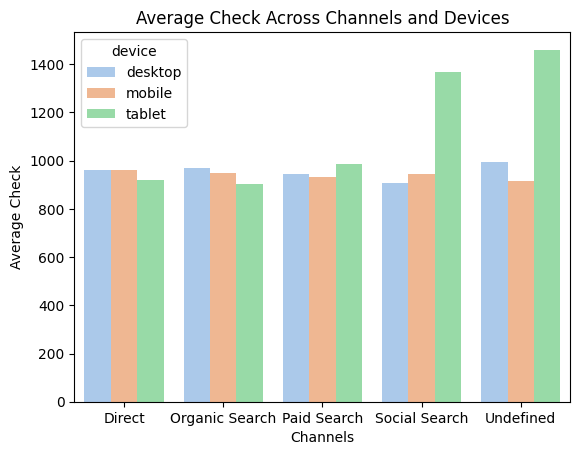

In [ ]:
# Середній чек у розрізі каналів та девайсів
group_by_channel_and_device_avg_sales = df.groupby(["channel", "device"])["sales"].mean().reset_index()
print(group_by_channel_and_device_avg_sales)
sns.barplot(data=group_by_channel_and_device_avg_sales, x="channel", y="sales", errorbar=("ci", False), hue = "device", palette ="pastel")
plt.title("Average Check Across Channels and Devices")
plt.xlabel("Channels")
plt.ylabel("Average Check")
plt.show()

Середній чек на Desktop стабільний у всіх каналах (1000 - 1100).
Середній чек на Mobile нижчий (900 - 1000), особливо в Undefined каналі.
Tablet має найвищий середній чек у всіх каналах (до 1400+), особливо в Social Search та Undefined.

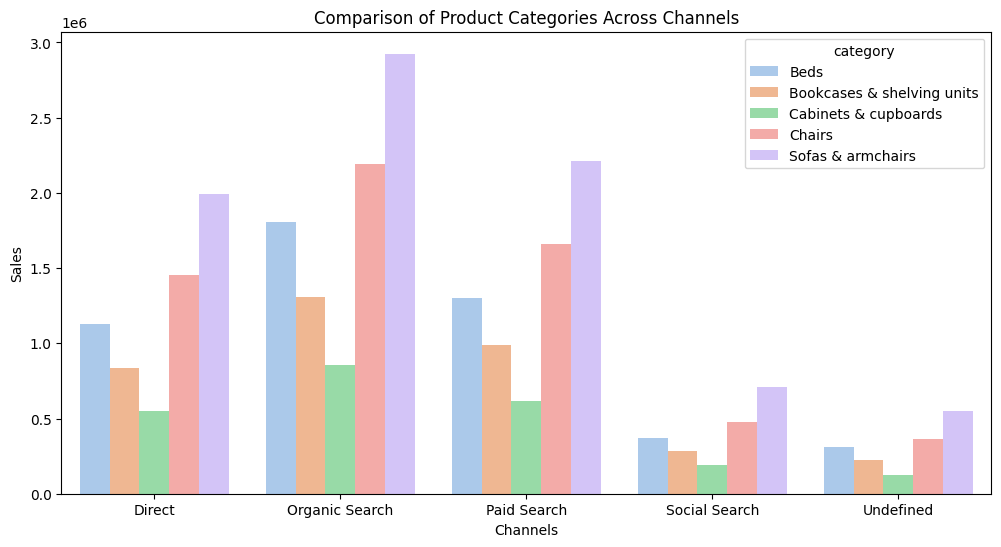

In [ ]:
# Взаємозв’язок канал + категорія товару
top_5_categories = df.groupby(["category"])["sales"].sum().reset_index().sort_values(by = "sales", ascending = False).head(5)
group_by_channel_and_category = df.groupby(["channel","category"])["sales"].sum().reset_index()
group_by_channel_and_category = group_by_channel_and_category[group_by_channel_and_category["category"].isin(top_5_categories["category"].tolist())]
plt.subplots(figsize=(12, 6))
sns.barplot(data=group_by_channel_and_category, x="channel", y="sales", errorbar=("ci", False), hue = "category", palette ="pastel")
plt.title("Comparison of Product Categories Across Channels")
plt.xlabel("Channels")
plt.ylabel("Sales")
plt.show()


Sofas & armchairs найвищі продажі у більшості каналів, особливо Organic Search та Paid Search.
Chairs високі продажі у Direct та Social Search.
Beds найбільші продажі через Paid Search.
Bookcases & shelving units середні продажі, найбільше через Organic Search.
Cabinets & cupboard найнижчі продажі у всіх каналах.


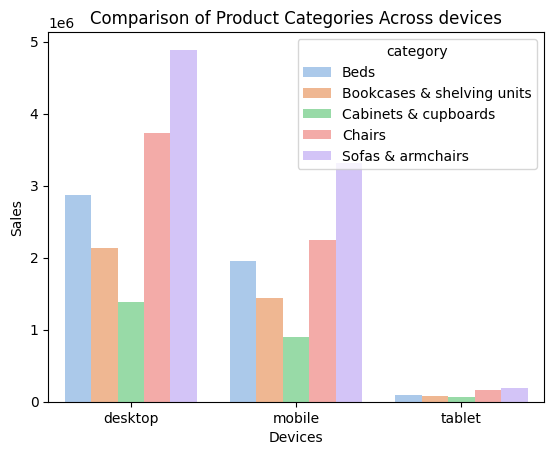

In [ ]:
# Взаємозв’язок девайс + категорія товару
group_by_device_and_category = df.groupby(["device","category"])["sales"].sum().reset_index()
group_by_device_and_category = group_by_device_and_category[group_by_device_and_category["category"].isin(top_5_categories["category"].tolist())]
sns.barplot(data=group_by_device_and_category, x="device", y="sales", errorbar=("ci", False), hue = "category", palette ="pastel")
plt.title("Comparison of Product Categories Across devices")
plt.xlabel("Devices")
plt.ylabel("Sales")
plt.show()

Продажі найбільші на desktop для всіх категорій.
Sofas & armchairs - абсолютний лідер у кожному каналі.
Chairs мають високі продажі на mobile.
Tablet показує найнижчі результати у всіх категоріях.

#Аналіз динаміки продажів

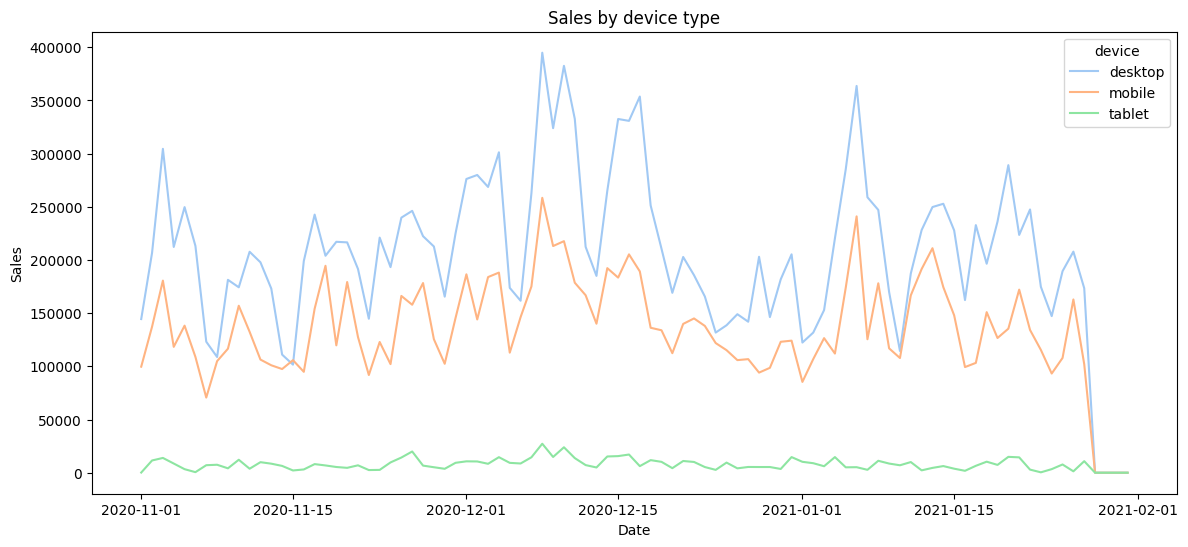

In [ ]:
# Динаміка продажів у розрізі девайсів
group_by_date_and_devices = df.groupby(["date","device"])["sales"].sum().reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(data = group_by_date_and_devices, x="date", y ="sales", hue = "device", palette ="pastel")
plt.title("Sales by device type")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

Продажі через desktop стабільно найвищі, але з великими коливаннями,  це головний драйвер продажів, чутливий до сезонних факторів та акцій.
Mobile має нижчі показники, проте теж демонструє динаміку з помітними піками.
Tablet залишається стабільно низьким каналом без значних змін.

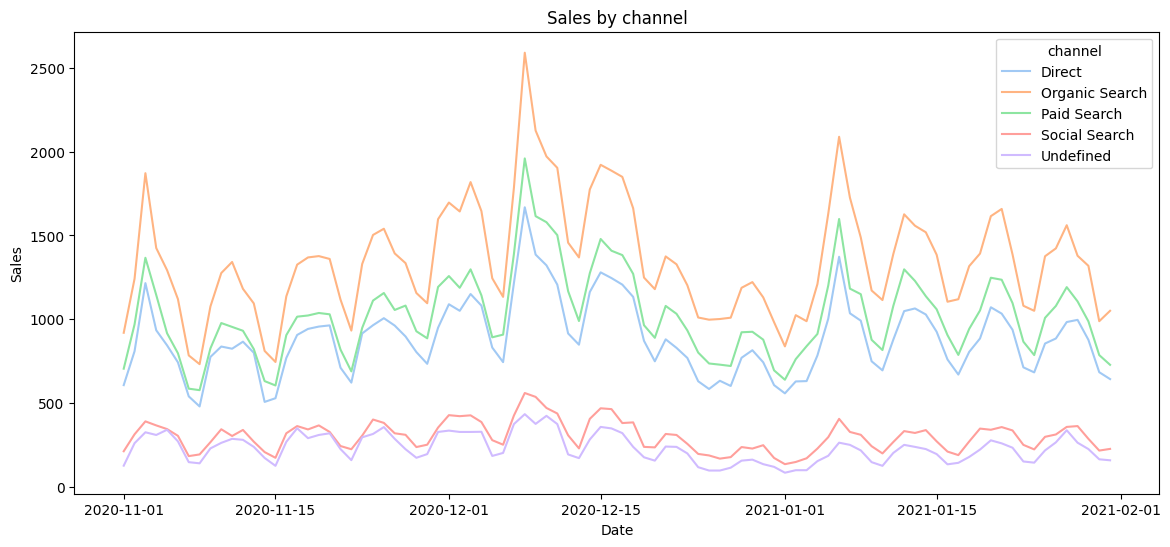

In [ ]:
# Динаміка кількості сесій у розрізі каналів
group_by_date_and_channel = df.groupby(["date","channel"])["ga_session_id"].count().reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(data = group_by_date_and_channel, x="date", y ="ga_session_id", hue = "channel", palette ="pastel")
plt.title("Sales by channel")
plt.xlabel("Date")
plt.ylabel("Sales")
plt.show()

Organic Search стабільно має найвищі продажі та піки.
Paid Search займає друге місце, але поступається органічному трафіку.
Direct канал також приносить суттєві продажі, підтверджуючи силу бренду.
Social Search та Undefined мають найнижчі показники.

#Зведені таблиці

                        ga_session_id
channel        device                
Direct         desktop          47825
               mobile           31745
               tablet            1812
Organic Search desktop          72622
               mobile           49014
               tablet            2789
Paid Search    desktop          55167
               mobile           37034
               tablet            2140
Social Search  desktop          16288
               mobile           10988
               tablet             638
Undefined      desktop          12527
               mobile            8486
               tablet             470


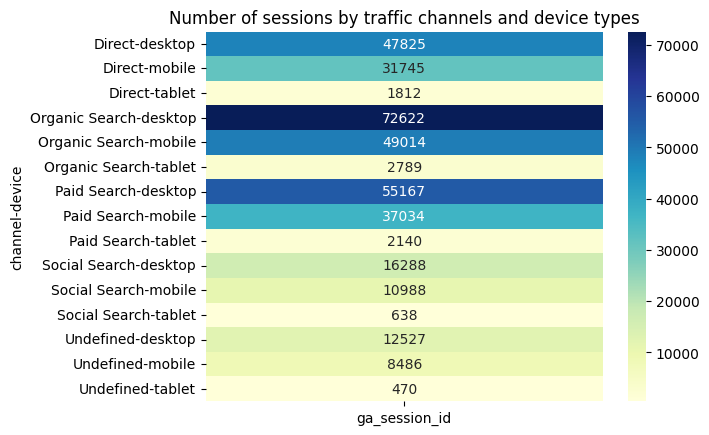

In [ ]:
# Зведена таблиця, яка показує кількість сесій у розрізі каналів трафіку та типів девайсів
pivot_table_1 = pd.pivot_table(df, index= ["channel", "device"] , values="ga_session_id", aggfunc="count")
print(pivot_table_1)
sns.heatmap(pivot_table_1, fmt='.0f',annot=True, cmap="YlGnBu")
plt.title("Number of sessions by traffic channels and device types")
plt.show()

Найбільше сесій приходить з Organic Search - це головний канал залучення користувачів.
Paid Search також має високі показники (desktop - 55 167; mobile - 37 034), підтверджуючи ефективність платних кампаній.
Direct канал демонструє суттєві результати (desktop - 47 825; mobile - 31 745), що свідчить про силу бренду та лояльність клієнтів.
Social Search та Undefined мають значно менші обсяги, особливо на tablet.
У всіх каналах tablet показує найнижчі значення.

                        account_id
channel        device             
Direct         desktop        3894
               mobile         2466
               tablet          154
Organic Search desktop        5837
               mobile         3966
               tablet          232
Paid Search    desktop        4355
               mobile         2940
               tablet          172
Social Search  desktop        1289
               mobile          866
               tablet           57
Undefined      desktop        1042
               mobile          640
               tablet           35


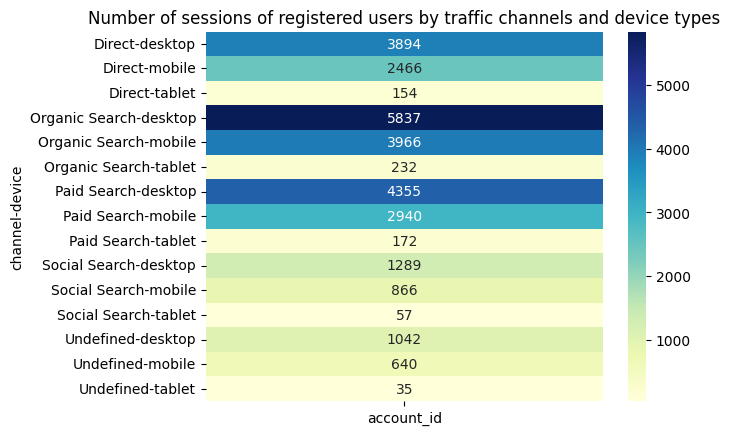

In [ ]:
# Зведена таблиця, яка показує кількість сесій зареєстрованих користувачів у розрізі каналів трафіку та типів девайсів
pivot_table_2 = pd.pivot_table(df, index= ["channel","device"] , values="account_id", aggfunc="count")
print(pivot_table_2)
sns.heatmap(pivot_table_2, fmt='.0f',annot=True, cmap="YlGnBu")
plt.title("Number of sessions of registered users by traffic channels and device types")
plt.show()

Найбільше сесій зареєстрованих користувачів приходить з Organic Search,
Paid Search також має високі показники, Direct канал демонструє суттєві результати.Social Search та Undefined мають значно менші обсяги, особливо на tablet. У всіх каналах tablet показує найнижчі значення.

#Статистичний аналіз взаємозв’язків

In [ ]:
# Зведена таблиця у розрізі каналів трафіку по продажам для аналізу кореліції
pivot_table_channels = pd.pivot_table(df, index= ["date"], columns="channel", values="sales", aggfunc="sum")

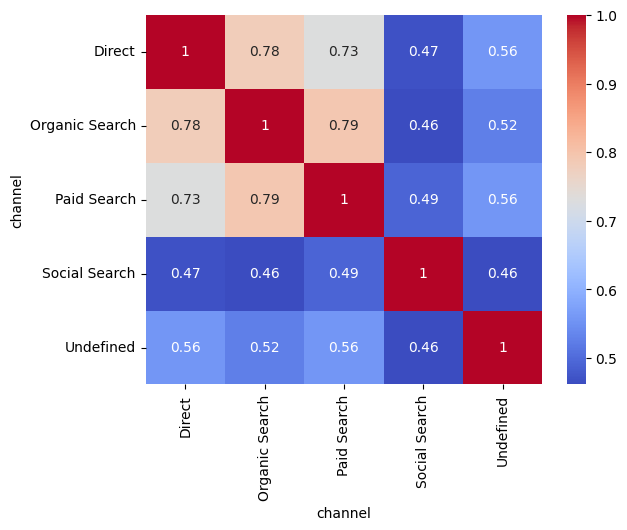

In [ ]:
# Створення кореляційної матриці для розразунку кореляції між різними каналами трафіку
corr_matrix = pivot_table_channels.corr(method="spearman")

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.show()

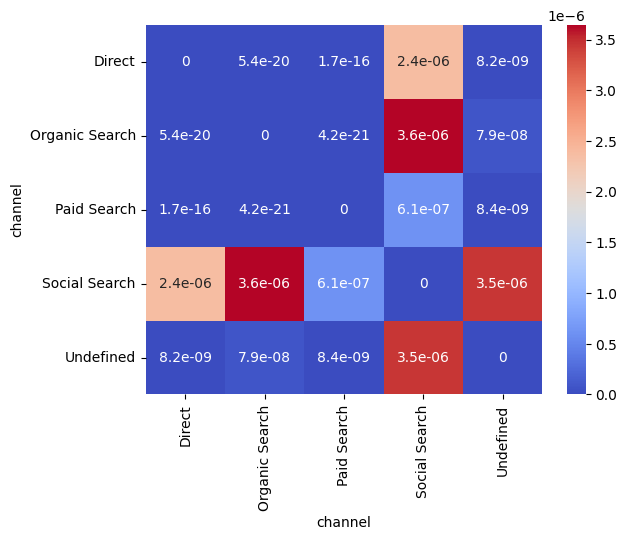

In [ ]:
# Створення матриці для розразунку p-value
cols = pivot_table_channels.columns
pval_matrix = pd.DataFrame(np.zeros((len(cols), len(cols))), columns=cols, index=cols)
for i in range(len(cols)):
  for j in range(len(cols)):
    corr, pval = spearmanr(pivot_table_channels[cols[i]], pivot_table_channels[cols[j]])
    pval_matrix.iloc[i, j] = pval

# Створення  heatmap
sns.heatmap(pval_matrix, annot=True, cmap="coolwarm")
plt.show()

Сильні кореляції у пар Direct та Organic Search (0.75) — тісний зв’язок, продажі зростають паралельно.
Organic Search та Paid Search (0.76) - висока кореляція, платний і органічний пошук працюють у зв’язці.
Direct та Paid Search (0.69) - теж сильний зв’язок.

Direct та Social Search (0.39) - слабка залежність
Organic Search та Social Search (0.38) - також слабка кореляція.
Paid Search та Social Search (0.42) - середня залежність.
Undefined та інші канали (0.39–0.49) - помірні кореляції, цей канал поводиться більш незалежно.

In [ ]:
# Зведена таблиця у розрізі девайсів для аналізу кореліції
pivot_table_device = pd.pivot_table(df, index= ["date"], columns="device", values="sales", aggfunc="sum")


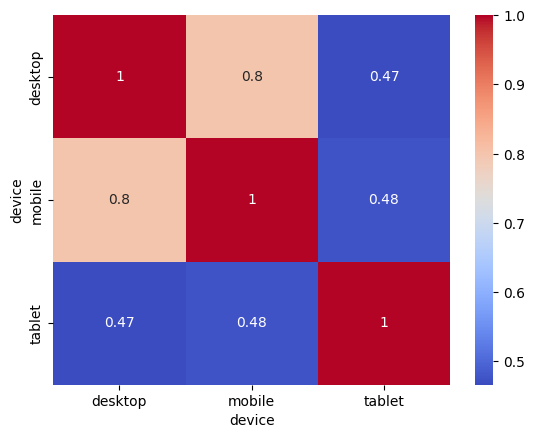

In [ ]:
# Створення кореляційної матриці для розразунку кореляції між девайсами
corr_matrix_device = pivot_table_device.corr(method="spearman")
# Створення  heatmap
sns.heatmap(corr_matrix_device, annot=True, cmap="coolwarm")
plt.show()

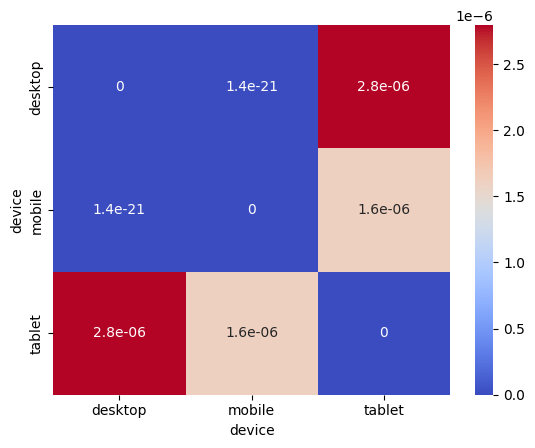

In [ ]:
# Створення матриці для розразунку p-value
cols_dev = pivot_table_device.columns
pval_matrix_device = pd.DataFrame(np.zeros((len(cols_dev), len(cols_dev))), columns=cols_dev, index=cols_dev)
for i in range(len(cols_dev)):
  for j in range(len(cols_dev)):
    corr, pval = spearmanr(pivot_table_device[cols_dev[i]], pivot_table_device[cols_dev[j]])
    pval_matrix_device.iloc[i, j] = pval

# Створення  heatmap
sns.heatmap(pval_matrix_device, annot=True, cmap="coolwarm")
plt.show()

Сила зв’язку Desktop та Mobile: 0.77.
Desktop та Tablet: 0.39 - слабка кореляція.
Mobile та Tablet: 0.40. Також слабка кореляція.

In [ ]:
# Зведена таблиця у розрізі девайсів для аналізу кореліції
pivot_table_device_ses = pd.pivot_table(df, index= ["date"], columns="device", values = "ga_session_id", aggfunc="count")

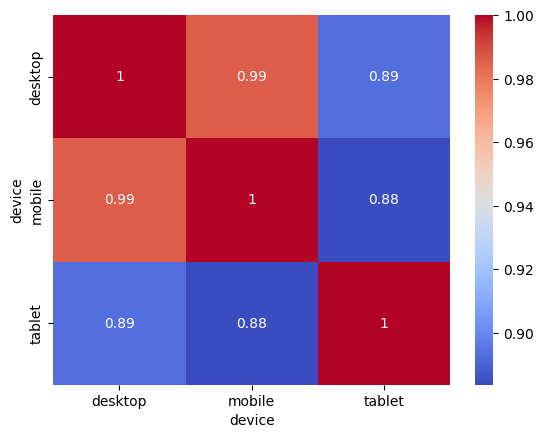

In [ ]:
# Створення кореляційної матриці для розразунку кореляції між девайсами за кількістю сесій
corr_matrix_device_ses = pivot_table_device_ses.corr(method="spearman")
# Створення  heatmap
sns.heatmap(corr_matrix_device_ses, annot=True, cmap="coolwarm")
plt.show()

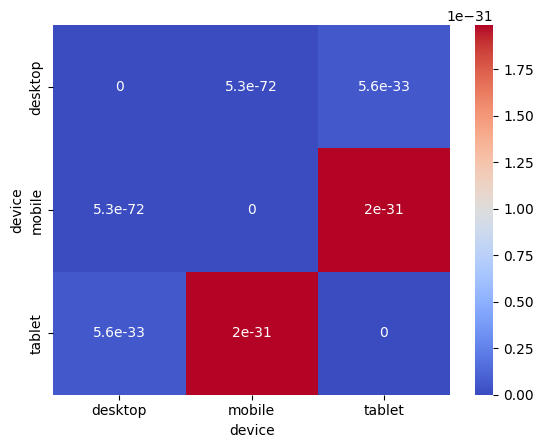

In [ ]:
# Створення матриці для розразунку p-value
cols_dev_ses = pivot_table_device_ses.columns
pval_matrix_device_ses = pd.DataFrame(np.zeros((len(cols_dev_ses), len(cols_dev_ses))), columns=cols_dev_ses, index=cols_dev_ses)
for i in range(len(cols_dev_ses)):
  for j in range(len(cols_dev_ses)):
    corr, pval = spearmanr(pivot_table_device_ses[cols_dev_ses[i]], pivot_table_device_ses[cols_dev_ses[j]])
    pval_matrix_device_ses.iloc[i, j] = pval

# Створення  heatmap
sns.heatmap(pval_matrix_device_ses, annot=True, cmap="coolwarm")
plt.show()

Взаємозв’язок між каналами Desktop та Mobile: дуже сильна кореляція (0.99).
Desktop та Tablet: висока, але трохи нижча кореляція (0.89).
Mobile та Tablet: також висока (0.88), але слабша, ніж між desktop і mobile.

#Статистичний аналіз відмінностей між групами

Direct: statistic=0.970, p-value=0.034
 -> Розподіл НЕ нормальний
Organic Search: statistic=0.964, p-value=0.012
 -> Розподіл НЕ нормальний
Paid Search: statistic=0.963, p-value=0.011
 -> Розподіл НЕ нормальний
Social Search: statistic=0.979, p-value=0.141
 -> Розподіл близький до нормального
Undefined: statistic=0.973, p-value=0.055
 -> Розподіл близький до нормального
Statistic: 368.98057369864847
p-value: 1.397036102599359e-78
Є статистично значущі відмінності між групами.


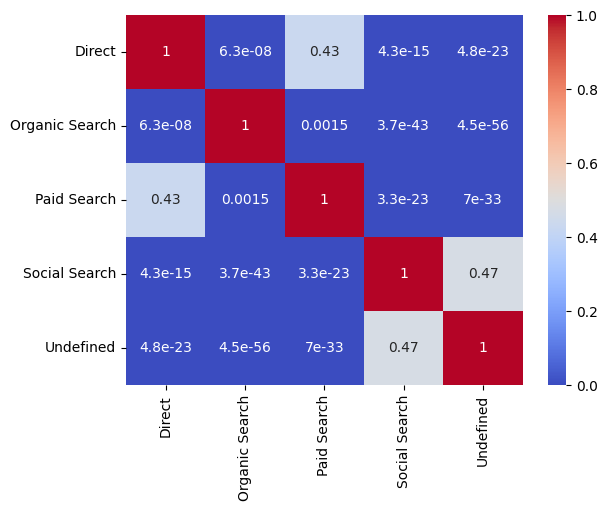

In [ ]:
pivot_table_channels_ses = pd.pivot_table(df, index= ["date"], columns="channel",values = "ga_session_id", aggfunc="count")

# дослідження на нормальність
for col in pivot_table_channels_ses.columns:
  stat, p = shapiro(pivot_table_channels_ses[col])
  print(f"{col}: statistic={stat:.3f}, p-value={p:.3f}")
  if p > 0.05:
    print(" -> Розподіл близький до нормального")
  else:
    print(" -> Розподіл НЕ нормальний")

# Тест Kruskal–Wallis
stat, p_value = kruskal(pivot_table_channels_ses["Direct"], pivot_table_channels_ses["Organic Search"],
                        pivot_table_channels_ses["Paid Search"], pivot_table_channels_ses["Social Search"], pivot_table_channels_ses["Undefined"])
print("Statistic:", stat)
print("p-value:", p_value)
if p_value < 0.05:
  print("Є статистично значущі відмінності між групами.")
else:
  print("Немає статистично значущих відмінностей.")

# Dunn’s test
df_long_channel = pivot_table_channels_ses.melt(var_name="Channel", value_name="Sessions")
posthoc_channel = sp.posthoc_dunn(df_long_channel, val_col="Sessions", group_col="Channel", p_adjust="bonferroni")
sns.heatmap(posthoc_channel, annot=True, cmap="coolwarm")
plt.show()

Direct і Paid Search можна розглядати як канали з подібною ефективністю.

Social і Undefined теж не мають значущих відмінностей, їхня роль у трафіку близька.

Решта каналів суттєво відрізняються, що варто враховувати при розподілі бюджету та аналізі ефективності.

desktop: statistic=0.963, p-value=0.011
 -> Розподіл НЕ нормальний
mobile: statistic=0.976, p-value=0.088
 -> Розподіл близький до нормального
tablet: statistic=0.973, p-value=0.055
 -> Розподіл близький до нормального
Statistic: 216.68323764502736
p-value: 8.868144988076332e-48
Є статистично значущі відмінності між групами.


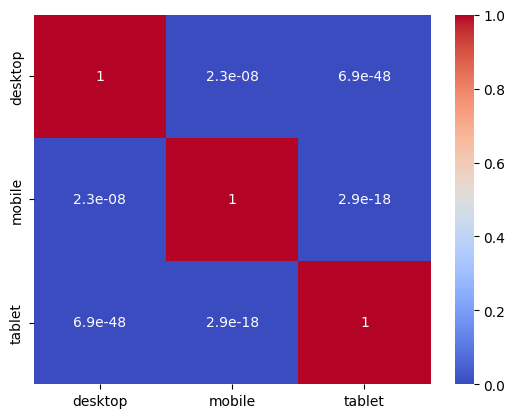

In [ ]:
# Кількість сесій за різними device
pivot_table_device_ses
# дослідження на нормальність
for col in pivot_table_device_ses .columns:
  stat, p = shapiro(pivot_table_device_ses[col])
  print(f"{col}: statistic={stat:.3f}, p-value={p:.3f}")
  if p > 0.05:
    print(" -> Розподіл близький до нормального")
  else:
    print(" -> Розподіл НЕ нормальний")

# Тест Kruskal–Wallis
stat, p_value = kruskal(pivot_table_device_ses["desktop"],pivot_table_device_ses["mobile"],
                        pivot_table_device_ses["tablet"])
print("Statistic:", stat)
print("p-value:", p_value)
if p_value < 0.05:
  print("Є статистично значущі відмінності між групами.")
else:
  print("Немає статистично значущих відмінностей.")

# Dunn’s test
df_long_device = pivot_table_device_ses.melt(var_name="Device", value_name="Sessions")
posthoc_device = sp.posthoc_dunn(df_long_device, val_col="Sessions", group_col="Device", p_adjust="bonferroni")
sns.heatmap(posthoc_device, annot=True, cmap="coolwarm")
plt.show()

Групи статистично різні, тобто кількість сесій на desktop, mobile і tablet має суттєві відмінності.
Кожен девайс це окремий сегмент: користувачі desktop, mobile і tablet мають різні рівні активності.
Не можна об’єднувати всі пристрої в одну стратегію: потрібні окремі підходи до маркетингу, UX та прогнозування.
Desktop і Mobile можуть мати схожі тренди (як показує кореляція), але рівні сесій відрізняються статистично.
Tablet - найбільш відмінний сегмент, який варто аналізувати окремо.

#Висновок

По каналам продажу:
* Organic Search - лідер за продажами та кількістю сесій, що забезпечує
найбільший потік користувачів та продажів.
* Paid Search - другий за значенням канал, добре працює як інструмент швидкого залучення, але менш стабільний.
* Direct - підтверджує силу бренду та лояльність клієнтів, має суттєві результати.
* Social Search та Undefined — найменш ефективні канали, їхня роль другорядна. Канал Undefined потрібно додатково дослідити.

По пристроям:
* Desktop - основний сегмент із найбільшими продажами та кількістю сесій, але чутливий до сезонних факторів та акцій.
* Mobile - другий за значенням сегмент, має нижчий середній чек, але високий обсяг сесій.
* Tablet  -найменший сегмент за кількістю сесій, проте має найвищий середній чек, що робить його цікавим для преміум-пропозицій та додаткових досліджень.

По категоріям товарів:
* Sofas & armchairs - абсолютний лідер у всіх каналах і на всіх пристроях.
* Chairs- сильні продажі на mobile та в Direct/Social Search.
* Beds - найбільше продаються через Paid Search.
* Bookcases & shelving units має середні продажі, особливо через Organic Search.
* Cabinets & cupboards має найнижчі продажі.

Статистичні інсайти:
* Є сильна кореляція між Organic Search і Paid Search, а також між Desktop і Mobile ці сегменти рухаються синхронно.
* Кількість сесій на desktop, mobile і tablet статистично відрізняється, тому кожен девайс потребує окремої стратегії.
* Direct і Paid Search мають подібну ефективність, Social і Undefined теж близькі між собою, решта каналів суттєво відрізняються.

Organic Search (лідер) скільки це найефективніший канал, варто інвестувати в SEO-контент, особливо для категорії Sofas & armchairs.
Desktop vs Mobile враховуючи різницю у середньому чеку, для desktop варто підтримувати високі продажі та робити акценти на преміум - категорії, тоді як mobile оптимізувати дизайн для швидких покупок ("покупки находу" та імпульсивних рішень).
Tablet-сегмент має високий середній чек при низькому трафіку — це можливість розвинути даний сегмент для продажу преміум-категорій.
Канал "Undefined" - варто дослідити окремо та індетинфікувати джерела цього трафіку, що є критично важливим.



#Аналітичний дашборд у Tableau Public
https://public.tableau.com/shared/MN45ZPFDJ?:display_count=n&:origin=viz_share_link